In [1]:
from scipy.io import savemat
import argparse
import pickle
import os
import torch
import cmath
import scipy.special
import os
import torch.nn as nn
from matplotlib.patches import Ellipse
import shutil
import math
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def kernel_ode(X,Y,l=1):
    
    length_X=np.size(X)
    length_Y=np.size(Y)
    
    Sigma=np.zeros([length_X, length_Y])

    for i in range(length_X):
        for k in range(length_Y):
            t=X[i]
            tp=Y[k]
            Sigma[i,k]=5*np.exp(-0.5*(t-tp)*(t-tp)/l/l)
    return Sigma

In [3]:
class BallDataset(torch.utils.data.Dataset):
    def __init__(self, trajs, figs):
        self.trajs = trajs.view(-1, 2)
        _, _, px, py = figs.shape
        self.figs = figs.view(-1, px * py)

    def __getitem__(self, index):
        x = self.figs[index]
        y = self.trajs[index]

        return x.float(), y.float()

    def __len__(self):
        return self.trajs.size(0)

In [4]:
def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
        cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
        if not torch.sum(cond):
            break
        t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
    return t

class VAEEncoder(torch.nn.Module):
    def __init__(self, batch, tmax, px, py):
        super(VAEEncoder,self).__init__()
        self.batch = batch
        self.tmax = tmax
        self.px = px
        self.py = py

        self.encoder = nn.Sequential(
            #Conv1
            #Grayscape
            nn.Conv2d(in_channels=1, out_channnels=96, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            #Conv2
            nn.Conv2d(in_channels=96, out_channnels=256, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            #Conv3
            nn.Conv2d(in_channels=256, out_channnels=512, kernel_size=3, stride=1),
            nn.ReLU(),
            
            #Conv4
            nn.Conv2d(in_channels=512, out_channnels=512, kernel_size=3, stride=1),
            nn.ReLU(),
            
            #Conv5
            nn.Conv2d(in_channels=512, out_channnels=512, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            #Full6
            nn.Linear(px * py * 512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            #Full6
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            #
            nn.Linear(2048, 4),     
            nn.Tanh(),
        )

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = truncated_normal(m.weight.data, std=1.0 / math.sqrt(float(m.in_features)))
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        out = self.encoder(x)
        out = out.view(self.batch, -1, 4)
        mean = out[:, :, :2]
        var = torch.exp(out[:, :, 2:])
        return mean, var

class VAEDecoder(torch.nn.Module):
    def __init__(self, batch, tmax, px, py):
        super(VAEDecoder,self).__init__()
        self.batch = batch
        self.tmax = tmax
        self.px = px
        self.py = py

        self.decoder = nn.Sequential(
            nn.Linear(2, 500),
            nn.Tanh(),
            nn.Linear(500, px * py),
        )

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = truncated_normal(m.weight.data, std=1.0 / math.sqrt(float(m.in_features)))
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        out = self.decoder(x)
        out = out.view(-1, self.px, self.py)
        return out

In [5]:
def gauss_cross_entropy(mu1, var1, mu2, var2):
    """
    Computes the element-wise cross entropy
    Given q(z) ~ N(z| mu1, var1)
    returns E_q[ log N(z| mu2, var2) ]
    args:
        mu1:  mean of expectation (batch, tmax, 2) tf variable
        var1: var  of expectation (batch, tmax, 2) tf variable
        mu2:  mean of integrand (batch, tmax, 2) tf variable
        var2: var of integrand (batch, tmax, 2) tf variable

    returns:
        cross_entropy: (batch, tmax, 2) tf variable
    """

    term0 = 1.8378770664093453 # log(2*pi)
    term1 = torch.log(torch.abs(var2)) 
    term2 = (var1 + mu1**2 - 2 * mu1 * mu2 + mu2**2) / (torch.abs(var2)) 

    cross_entropy = -0.5*(term0 + term1 + term2)

    return cross_entropy

In [6]:
global_nx = 0
global_ny = 0
global_K_x = None
global_K_y = None

def build_1d_gp(X, Y, varY, X_test,args_l1,args_l2,args_d1,args_d2, lt=5, xaxis=True):
    """
    Takes input-output dataset and returns post mean, var, marginal lhood.
    This is standard GP regression (in this application X is time, Y is 
    recognition network means with noise as recognition netowrk variance).

    Args:
        X: inputs tensor (batch, npoints)
        Y: outputs tensor (batch, npoints)
        varY: noise of outputs tensor (batch, npoints)
        X_test: (batch, ns) input points to compute post mean + var

    Returns:
        p_m: (batch, ns) post mean at X_test
        p_v: (batch, ns) post var at X_test
        logZ: (batch) marginal lhood of each dataset in batch
    """
    global global_nx
    global global_ny
    global global_K_x
    global global_K_y

    # Prepare all constants
    batch, n = X.shape
    ns = X_test.shape[1]
    
    
    # lhood term 1/3
    lhood_pi_term = n * torch.log(torch.tensor([2*np.pi]))
    
    # data cov matrix
    new_X = np.arange(n)

    # Recompute covariance matrix if it is the first time of if the input size changed
    if xaxis:
        if global_K_x is None:
            one_kernel = kernel_ode(new_X, new_X, l=lt)
            global_K_x = one_kernel
        else:
            one_kernel = global_K_x
    else:
        if global_K_y is None:
            one_kernel = kernel_ode(new_X, new_X, l=lt)
            global_K_y = one_kernel
        else:
            one_kernel = global_K_y
    #if not np.all(np.linalg.eigvals(one_kernel) > 0):
    #    raise ValueError

    K_array = [torch.tensor(one_kernel) for _ in range(batch)]
    K = torch.stack(K_array)
    K = K.type(torch.FloatTensor)  
    chol_K = torch.linalg.cholesky(K + torch.diag_embed(varY) ) # (batch, n, n)

    # print("chol_K = ", chol_K)

    # lhood term 2/3
    lhood_logdet_term = 2*torch.sum(torch.log(torch.diagonal(chol_K, dim1=-2, dim2=-1)), 1) # (batch)

    # lhood term 3/3
    Y = torch.reshape(Y, (batch, n, 1))
    iKY = torch.cholesky_solve(Y, chol_K) # (batch, n, 1)
    lh_quad_term = torch.matmul(torch.reshape(Y, (batch, 1, n)), iKY) # (batch, 1, 1)
    lh_quad_term = torch.reshape(lh_quad_term, (batch, ))

    # log P(Y|X) = -1/2 * ( n log(2 pi) + Y inv(K+noise) Y + log det(K+noise))
    gp_lhood = -0.5*(lhood_pi_term + lh_quad_term + lhood_logdet_term)

    # Compute posterior mean and variances
    if np.array_equal(X,X_test):
        #K_array = [torch.tensor(one_kernel) for _ in range(batch)]
        #Ks = torch.stack(K_array)
        Ks = K
        iK_Ks = torch.cholesky_solve(Ks, chol_K) # (batch, n, ns)
         # Covariance matrix for posterior variance. Can be simplified for stationary kernels
        diagK = [torch.diag(torch.diag(torch.tensor(one_kernel))) for _ in range(batch)]
        diagK = torch.stack(diagK)
        diagK = diagK.type(torch.FloatTensor)
        p_v = torch.sum(diagK - (Ks * iK_Ks), 1) # (batch, ns)
    else:
        test_X = np.arange(ns)
        if xaxis:
            one_kernel = kernel_ode(new_X, test_X, l=lt)
        else:
            one_kernel = kernel_ode(new_X, test_X, l=lt)    
        K_array = [torch.tensor(one_kernel) for _ in range(batch)]
        Ks = torch.stack(K_array)
        Ks = Ks.type(torch.FloatTensor)
        iK_Ks = torch.cholesky_solve(Ks, chol_K) # (batch, n, ns)
         # Covariance matrix for posterior variance. Can be simplified for stationary kernels
        if xaxis:
            one_kernel = kernel_ode(test_X, test_X, l=lt)
        else:
            one_kernel = kernel_ode(test_X, test_X, l=lt) 
        diagK = [torch.diag(torch.diag(torch.tensor(one_kernel))) for _ in range(batch)]
        diagK = torch.stack(diagK)
        diagK = diagK.type(torch.FloatTensor)
        p_v = torch.diagonal(diagK - torch.matmul(torch.transpose(Ks,1,2),iK_Ks), dim1=1, dim2=2) # (batch, ns)
    
    Ks_t = torch.transpose(Ks, 1, 2) # (batch, ns, n)

    # posterior mean
    p_m = torch.matmul(Ks_t, iKY)
    p_m = torch.reshape(p_m, (batch, ns))

    
    #Ks_iK_Ks = torch.sum(Ks * iK_Ks, 1) # (batch, ns)

    # posterior variance
    p_v = torch.reshape(p_v, (batch, ns))
    p_v = p_v+0.00001*torch.ones(p_v.shape)
    
    return p_m, p_v, gp_lhood

In [7]:
def MSE_scale(X, Y, VX=None):
    """
    Given X, rotate it onto Y
    args:
        X: np array (batch, tmax, 2)
        Y: np array (batch, tmax, 2)
        VX: variance of X values (batch, tmax, 2)

    returns:
        X_rot: rotated X (batch, tmax, 2)
        W: nparray (2, 2)
        B: nparray (2, 1)
        MSE: ||X_rot - Y||^2
        VX_rot: rotated cov matrices (default zeros)
    """

    batch, tmax, _ = X.shape

    X1 = X[:,:,0].reshape(batch*tmax, 1)
    Y1 = Y[:,:,0].reshape(batch*tmax, 1)
    X2 = X[:,:,1].reshape(batch*tmax, 1)
    Y2 = Y[:,:,1].reshape(batch*tmax, 1)

    X = X.reshape((batch*tmax, 2)).numpy()

    Y = Y.reshape(batch*tmax, 2)

    W1, MSE1, _, _ = np.linalg.lstsq(X1, Y1, rcond=None)
    W2, MSE2, _, _ = np.linalg.lstsq(X2, Y2, rcond=None)

    W=np.array([[W1.item(), 0], [0, W2.item()]])
    MSE=MSE1 + MSE2

    try:
        MSE = MSE[0] + MSE[1]
    except:
        MSE = np.nan

    X_rot = np.matmul(X, W)
    X_rot = X_rot.reshape(batch, tmax, 2)


    VX_rot = np.zeros((batch, tmax, 2, 2))
    if VX is not None:
        W_rot = W[:2,:]
        W_rot_t = np.transpose(W[:2,:])
        for b in range(batch):
            for t in range(tmax):
                VX_i = np.diag(VX[b,t,:])
                VX_i = np.matmul(W_rot, VX_i)
                VX_i = np.matmul(VX_i, W_rot_t)
                VX_rot[b,t,:,:] = VX_i

    return X_rot, W, MSE, VX_rot

def MSE_rotation(X, Y, VX=None):
    """
    Given X, rotate it onto Y
    args:
        X: np array (batch, tmax, 2)
        Y: np array (batch, tmax, 2)
        VX: variance of X values (batch, tmax, 2)

    returns:
        X_rot: rotated X (batch, tmax, 2)
        W: nparray (2, 2)
        B: nparray (2, 1)
        MSE: ||X_rot - Y||^2
        VX_rot: rotated cov matrices (default zeros)
    """

    batch, tmax, _ = X.shape

    X = X.reshape((batch*tmax, 2))


    X = np.hstack([X, np.ones((batch*tmax, 1))])

    
    Y = Y.reshape(batch*tmax, 2)

    W, MSE, _, _ = np.linalg.lstsq(X, Y, rcond=None)

    try:
        MSE = MSE[0] + MSE[1]
    except:
        MSE = np.nan

    X_rot = np.matmul(X, W)
    X_rot = X_rot.reshape(batch, tmax, 2)


    VX_rot = np.zeros((batch, tmax, 2, 2))
    if VX is not None:
        W_rot = W[:2,:]
        W_rot_t = np.transpose(W[:2,:])
        for b in range(batch):
            for t in range(tmax):
                VX_i = np.diag(VX[b,t,:])
                VX_i = np.matmul(W_rot, VX_i)
                VX_i = np.matmul(VX_i, W_rot_t)
                VX_rot[b,t,:,:] = VX_i

    return X_rot, W, MSE, VX_rot

def plot_latents(truevids, truepath, reconvids=None, reconpath=None, reconvar=None, ax=None, nplots=4, paths=None):
    """
    Plots an array of input videos and reconstructions.
    args:
        truevids: (batch, tmax, px, py) np array of videos
        truepath: (batch, tmax, 2) np array of latent positions
        reconvids: (batch, tmax, px, py) np array of videos
        reconpath: (batch, tmax, 2) np array of latent positions
        reconvar: (batch, tmax, 2, 2) np array, cov mat 
        ax: (optional) list of lists of axes objects for plotting
        nplots: int, number of rows of plot, each row is one video
        paths: (batch, tmax, 2) np array optional extra array to plot

    returns:
        fig: figure object with all plots

    """

    if ax is None:
        _, ax = plt.subplots(nplots,3, figsize=(6, 8))
    
    for axi in ax:
        for axj in axi:
            axj.clear()

    _, tmax, _, _ = truevids.shape


    # get axis limits for the latent space
    xmin = np.min([truepath[:nplots,:,0].min(), 
                   reconpath[:nplots,:,0].min()]) -0.1
    xmin = np.min([xmin, -2.5])
    xmax = np.max([truepath[:nplots,:,0].max(), 
                   reconpath[:nplots,:,0].max()]) +0.1
    xmax = np.max([xmax, 2.5])

    ymin = np.min([truepath[:nplots,:,1].min(), 
                   reconpath[:nplots,:,1].min()]) -0.1
    ymin = np.min([ymin, -2.5])
    ymax = np.max([truepath[:nplots,:,1].max(), 
                   reconpath[:nplots,:,1].max()]) +0.1
    ymax = np.max([xmax, 2.5])

    def make_heatmap(vid):
        """
        args:
            vid: tmax, px, py
        returns:
            flat_vid: px, py
        """
        vid = np.array([(t+4)*v for t,v in enumerate(vid)])
        flat_vid = np.max(vid, 0)*(1/(4+tmax))
        return flat_vid
    
    if reconvar is not None:
        E = np.linalg.eig(reconvar[:nplots,:,:,:])
        H = np.sqrt(E[0][:,:,0])
        W = np.sqrt(E[0][:,:,1])
        A = np.arctan2(E[1][:,:,0,1], E[1][:,:,0,0])*(360/(2*np.pi))

    def plot_set(i):
        # i is batch element = plot column

        # top row of plots is true data heatmap
        tv = make_heatmap(truevids[i,:,:,:])
        ax[0][i].imshow(1-tv, origin='lower', cmap='Greys')
        ax[0][i].axis('off')


        # middle row is trajectories
        ax[1][i].plot(truepath[i,:,0], truepath[i,:,1])
        ax[1][i].set_xlim([xmin, xmax])
        ax[1][i].set_ylim([ymin, ymax])
        ax[1][i].scatter(truepath[i,-1,0], truepath[i,-1,1])


        if reconpath is not None:
            ax[1][i].plot(reconpath[i,:,0], reconpath[i,:,1])
            ax[1][i].scatter(reconpath[i,-1,0], reconpath[i,-1,1])

        if paths is not None:
            ax[1][i].plot(paths[i,:,0], paths[i,:,1])
            ax[1][i].scatter(paths[i,-1,0], paths[i,-1,1])
        
        if reconvar is not None:
            ells = [Ellipse(xy=reconpath[i,t,:], 
                            width=W[i,t], 
                            height=H[i,t], 
                            angle=A[i,t]) for t in range(tmax)]
            for e in ells:
                ax[1][i].add_artist(e)
                e.set_clip_box(ax[1][i].bbox)
                e.set_alpha(0.25)
                e.set_facecolor('C1')

        # Third row is reconstructed video
        if reconvids is not None:
            rv = make_heatmap(reconvids[i,:,:,:])
            ax[2][i].imshow(1-rv, origin='lower', cmap='Greys')
            ax[2][i].axis('off')
    
    
    for i in range(nplots):
        plot_set(i)
    
    return ax

In [8]:
def run_experiment(args_steps,args_modellt,args_base_dir,args_l1,args_l2,args_d1,args_d2):
    # CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")


    # Data synthesis settings
    model_lt = args_modellt

    # Load/ceate batches of reproducible videos
    with open(args_base_dir + "/Test_Batches.pkl", "rb") as f:
        Test_Batches = pickle.load(f)

    with open(args_base_dir + "/Test_Batches_extrapolate.pkl", "rb") as f:
        Test_Batches_extrapolate = pickle.load(f)

    # Read parameters
    batch, tmax, px, py = Test_Batches[0][1].shape

    # Create train/test dataset and corresponding loaders
    T = torch.arange(tmax)
    batch_T = torch.cat([T.view(1,tmax) for i in range(batch)], 0) # (batch, tmax)

    TT, TD = Test_Batches[0]
    dataset_train = BallDataset(torch.tensor(TT), torch.tensor(TD))
    TT, TD = Test_Batches_extrapolate[0]
    dataset_test = BallDataset(torch.tensor(TT), torch.tensor(TD))
    
    _, tmax1, _, _ = Test_Batches_extrapolate[0][1].shape
    
    batch_size_train = batch * tmax
    batch_size_test = batch * tmax1
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False)

    # Create encoder and decoder
    encoder = VAEEncoder(batch, tmax, px, py).to(device)
    encoder.apply(encoder.initialize_weights)
    decoder = VAEDecoder(batch, tmax, px, py).to(device)
    decoder.apply(decoder.initialize_weights)

    # Set optimizer
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    # Train loop
    for epoch in range(args_steps):
        # Train
        encoder.train()
        decoder.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            qnet_mu, qnet_var = encoder(data.to(device))
            if(np.isnan(qnet_var.detach().numpy()).any()):
                print(full_lhoodx)
                print(full_lhoody)
                print(sin_elbo_ce)

            ####################################################################################
            #################### PriorKL 1/3: FULL APPROX POST AND LIKELIHOOD ##################

            # posterior and lhood for full dataset
            p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,:,0], qnet_var[:,:,0], batch_T,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=True)
            p_my, p_vy, full_lhoody = build_1d_gp(batch_T, qnet_mu[:,:,1], qnet_var[:,:,1], batch_T,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=False)

            full_p_mu = torch.stack([p_mx, p_my], 2)
            full_p_var = torch.stack([p_vx, p_vy], 2)

            full_lhood = full_lhoodx + full_lhoody

            ####################################################################################
            ########################### PriorKL 2/3: CROSS ENTROPY TERMS #######################

            # cross entropy term
            sin_elbo_ce = gauss_cross_entropy(full_p_mu, full_p_var, qnet_mu, qnet_var) #(batch, tmax, 2)
            sin_elbo_ce = torch.sum(sin_elbo_ce, (1, 2)) # (batch)

            ####################################################################################
            ################################ Prior KL 3/3 ######################################

            sin_elbo_prior_kl = full_lhood - sin_elbo_ce
            sin_elbo_prior_kl = torch.mean(sin_elbo_prior_kl)
            # print(torch.mean(full_lhood).item(), torch.mean(-sin_elbo_ce).item())
            
            ####################################################################################
            ########################### RECONSTRUCTION TERMS ###################################

            epsilon = torch.randn((batch, tmax, 2))
            latent_samples = full_p_mu + epsilon * torch.sqrt(full_p_var) #CHANGE +0.0000001
            pred_vid_batch_logits = decoder(latent_samples)
            pred_vid = torch.sigmoid(pred_vid_batch_logits)
            recon_err = nn.BCEWithLogitsLoss(reduction='sum')(pred_vid_batch_logits, data.view(-1, px, py))
            sin_elbo_recon = recon_err / batch

            # Total loss
            loss = sin_elbo_recon - 10.*sin_elbo_prior_kl #CHANGE

            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
            #torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)
            optimizer.step()

            if (epoch + 0) % 50 == 0:
                print('Train Epoch: {} \tLoss: {:.6f}\t {:.6f}\t {:.6f}'.format(
                        epoch, loss.item(), sin_elbo_recon.item(), -1.*sin_elbo_prior_kl.item()))
                mdic = {"epoch": epoch, "loss": loss.item(), "sin_elbo_recon": sin_elbo_recon.item(), "sin_elbo_prior_kl": sin_elbo_prior_kl.item()}
                savemat('data/train_epoch_' + str(epoch) + '.mat', mdic)
        # Test
        if (epoch + 0) % 1000 == 0:
            encoder.eval()
            decoder.eval()
            test_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    qnet_mu, qnet_var = encoder(data.to(device))

                    T_test = torch.arange(tmax1)
                    batch_T_test = torch.cat([T_test.view(1, tmax1) for i in range(batch)], 0) # (batch, tmax)

                    p_mx, p_vx, full_lhoodx = build_1d_gp(batch_T, qnet_mu[:,T,0], qnet_var[:,T,0], batch_T_test,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=True)
                    p_my, p_vy, full_lhoody = build_1d_gp(batch_T, qnet_mu[:,T,1], qnet_var[:,T,1], batch_T_test,args_l1,args_l2,args_d1,args_d2, lt=model_lt, xaxis=False)

                    full_p_mu = torch.stack([p_mx, p_my], 2)
                    full_p_var = torch.stack([p_vx, p_vy], 2)

                    epsilon = torch.randn((batch, tmax1, 2))
                    latent_samples = full_p_mu + epsilon * torch.sqrt(torch.clamp(full_p_var, 0, None)) #CHANGE +0.0000001 
                    pred_vid_batch_logits = decoder(latent_samples)
                    pred_vid = torch.sigmoid(pred_vid_batch_logits).view(batch, tmax1, px, py)

                    # Initialise a plots
                    # this plot displays a  batch of videos + latents + reconstructions
                    plt.clf()
                    fig, ax = plt.subplots(4,4, figsize=(7, 7), constrained_layout=True)

                    TT, TD = Test_Batches_extrapolate[0]

                    #rp, W, MSE, rv = MSE_scale(full_p_mu, TT, full_p_var)
                    rp, W, MSE, rv = MSE_rotation(full_p_mu, TT, full_p_var)
                    
                    plot_latents(TD[:,0:tmax,:,:], TT[:,0:tmax,:], pred_vid.numpy()[:,0:tmax,:,:], rp[:,0:tmax,:], rv[:,0:tmax,:,:], ax=ax, nplots=4)

                    plt.draw()
                    fig.suptitle(str(epoch)+' ELBO: ' + str(-loss.item()))
                    plt.show()

                    test_T = np.arange(tmax1)
                    id = 1

                    plt.clf()
                    plt.plot(test_T, TT[id, :, 0], 'k+', ms=14)
                    plt.plot(test_T, rp[id, :, 0], 'r')
                    plt.gca().fill_between(test_T, rp[id, :, 0]-2*rv[id, :, 0, 0], rp[id, :, 0]+2*rv[id, :, 0, 0], color="#ffff00")
                    plt.title('x Mean predictions plus 2 st.deviations')
                    plt.show()

                    plt.clf()
                    plt.plot(test_T, TT[id, :, 1], 'k+', ms=14)
                    plt.plot(test_T, rp[id, :, 1], 'r')
                    plt.gca().fill_between(test_T, rp[id, :, 1]-2*rv[id, :, 1, 1], rp[id, :, 1]+2*rv[id, :, 1, 1], color="#ffff00")
                    plt.title('y Mean predictions plus 2 st.deviations')
                    plt.show()

                    test_loss += nn.MSELoss()(torch.tensor(rp).view(-1, 2), target.to(device))
                    
                    mdic1 = {"epoch": epoch, "loss": loss.item(), "test_T": test_T, "true_path": TT, "pred_path": rp, "pred_path_var": rv}
                    savemat('data/test_epoch_' + str(epoch) + '.mat', mdic1)

            test_loss /= len(test_loader.dataset)
            print('\nTest set: Avg. loss: {:.4f}\n'.format(
                test_loss))

Train Epoch: 0 	Loss: 33878.937500	 33761.195312	 11.774060


<Figure size 432x288 with 0 Axes>

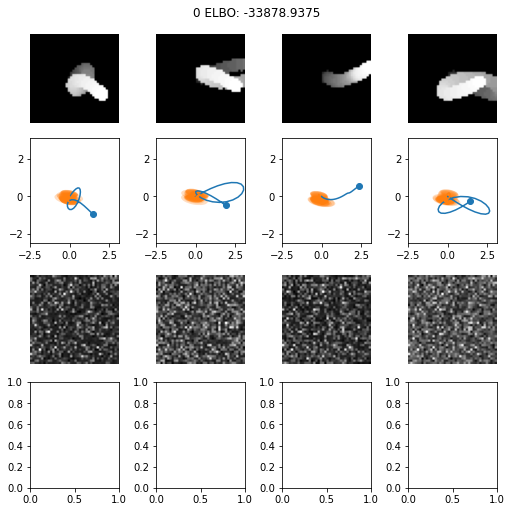

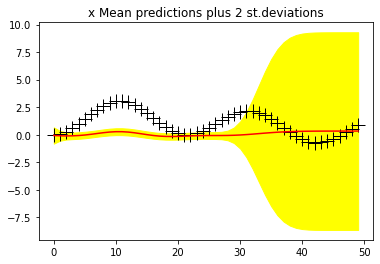

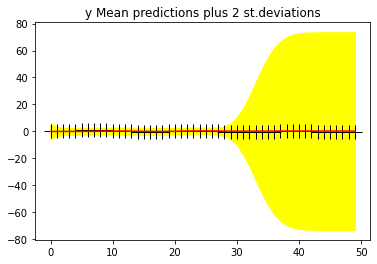


Test set: Avg. loss: 0.0004

Train Epoch: 50 	Loss: 3637.925049	 3270.491943	 36.743301
Train Epoch: 100 	Loss: 3193.687988	 2899.748047	 29.394005
Train Epoch: 150 	Loss: 3065.645752	 2787.379150	 27.826670
Train Epoch: 200 	Loss: 2944.971924	 2672.448975	 27.252302
Train Epoch: 250 	Loss: 2838.110352	 2562.471191	 27.563906
Train Epoch: 300 	Loss: 2752.901611	 2472.853760	 28.004786
Train Epoch: 350 	Loss: 2624.591309	 2332.693115	 29.189825
Train Epoch: 400 	Loss: 2548.808838	 2248.057617	 30.075123
Train Epoch: 450 	Loss: 2481.007568	 2173.612061	 30.739546
Train Epoch: 500 	Loss: 2431.966064	 2122.524902	 30.944124
Train Epoch: 550 	Loss: 2395.989990	 2084.523193	 31.146669
Train Epoch: 600 	Loss: 2346.148926	 2032.314331	 31.383469
Train Epoch: 650 	Loss: 2316.571045	 1998.526855	 31.804428
Train Epoch: 700 	Loss: 2289.254395	 1973.250366	 31.600395
Train Epoch: 750 	Loss: 2268.959229	 1950.736572	 31.822266
Train Epoch: 800 	Loss: 2244.316406	 1912.945312	 33.137104
Train Epoch

<Figure size 432x288 with 0 Axes>

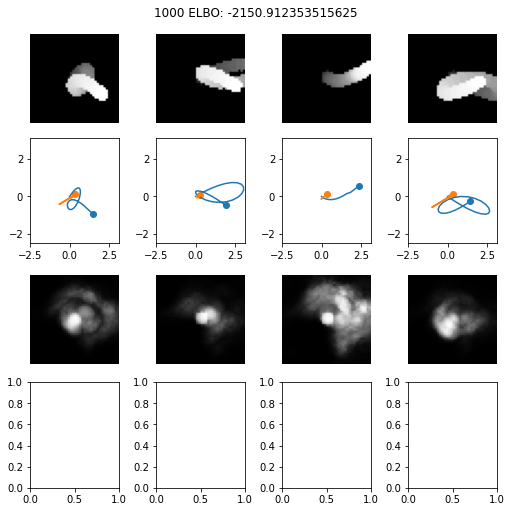

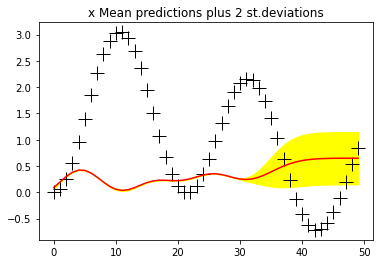

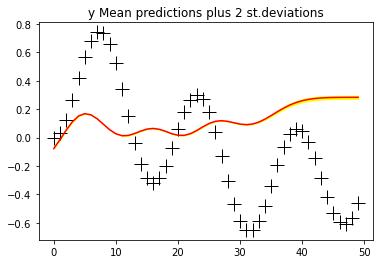


Test set: Avg. loss: 0.0004

Train Epoch: 1050 	Loss: 2133.550781	 1804.369629	 32.918102
Train Epoch: 1100 	Loss: 2122.164062	 1789.427490	 33.273666
Train Epoch: 1150 	Loss: 2100.598877	 1759.123413	 34.147541
Train Epoch: 1200 	Loss: 2081.540283	 1743.959229	 33.758102
Train Epoch: 1250 	Loss: 2055.140625	 1718.132324	 33.700829
Train Epoch: 1300 	Loss: 2029.820557	 1689.247559	 34.057293
Train Epoch: 1350 	Loss: 2015.838867	 1670.161621	 34.567719
Train Epoch: 1400 	Loss: 2004.416504	 1659.004639	 34.541183
Train Epoch: 1450 	Loss: 1982.329590	 1632.852783	 34.947678
Train Epoch: 1500 	Loss: 1964.957397	 1617.311523	 34.764591
Train Epoch: 1550 	Loss: 1993.489258	 1637.673584	 35.581570
Train Epoch: 1600 	Loss: 1934.557983	 1584.618164	 34.993980
Train Epoch: 1650 	Loss: 1914.859619	 1556.796387	 35.806316
Train Epoch: 1700 	Loss: 1910.321289	 1559.265991	 35.105522
Train Epoch: 1750 	Loss: 1878.310425	 1527.435425	 35.087502
Train Epoch: 1800 	Loss: 1876.967041	 1523.789795	 35.3

<Figure size 432x288 with 0 Axes>

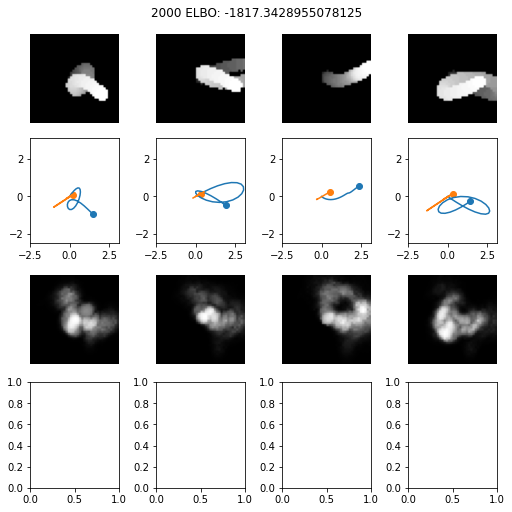

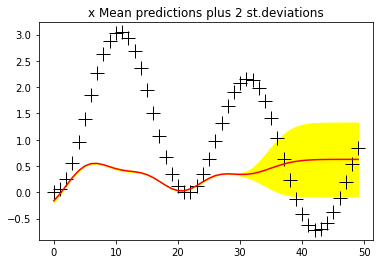

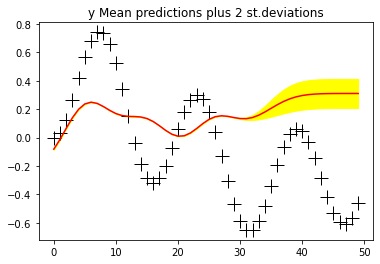


Test set: Avg. loss: 0.0003

Train Epoch: 2050 	Loss: 1805.867798	 1449.890625	 35.597717
Train Epoch: 2100 	Loss: 1786.235840	 1425.515015	 36.072090
Train Epoch: 2150 	Loss: 1777.352539	 1415.662476	 36.168999
Train Epoch: 2200 	Loss: 1773.142334	 1412.231934	 36.091034
Train Epoch: 2250 	Loss: 1753.227539	 1392.109985	 36.111759
Train Epoch: 2300 	Loss: 1732.402954	 1365.191528	 36.721146
Train Epoch: 2350 	Loss: 1721.557983	 1353.679688	 36.787830
Train Epoch: 2400 	Loss: 1715.007568	 1352.567871	 36.243965
Train Epoch: 2450 	Loss: 1697.468506	 1326.234253	 37.123428
Train Epoch: 2500 	Loss: 1672.714844	 1302.435791	 37.027908
Train Epoch: 2550 	Loss: 1680.043701	 1302.914062	 37.712959
Train Epoch: 2600 	Loss: 1666.748535	 1290.936401	 37.581215
Train Epoch: 2650 	Loss: 1650.297974	 1273.540894	 37.675709
Train Epoch: 2700 	Loss: 1644.197998	 1268.107178	 37.609081
Train Epoch: 2750 	Loss: 1630.282837	 1252.253418	 37.802944
Train Epoch: 2800 	Loss: 1619.949097	 1238.025635	 38.1

<Figure size 432x288 with 0 Axes>

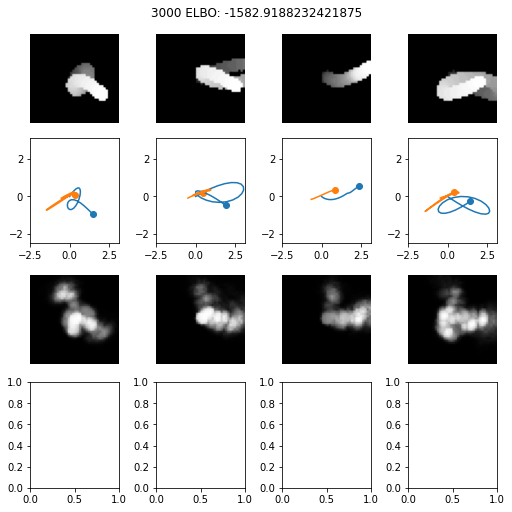

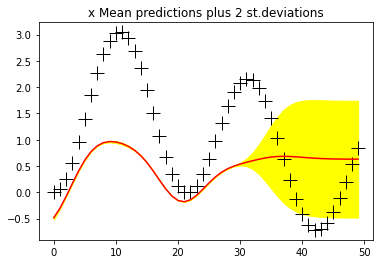

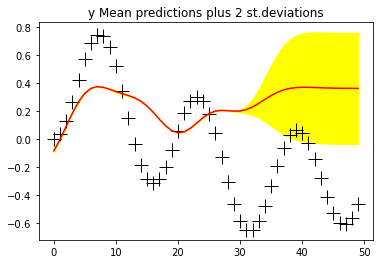


Test set: Avg. loss: 0.0003

Train Epoch: 3050 	Loss: 1572.791382	 1188.994263	 38.379715
Train Epoch: 3100 	Loss: 1563.348511	 1179.813232	 38.353527
Train Epoch: 3150 	Loss: 1555.749268	 1169.894897	 38.585442
Train Epoch: 3200 	Loss: 1596.651855	 1189.702026	 40.694988
Train Epoch: 3250 	Loss: 1542.650269	 1153.885254	 38.876503
Train Epoch: 3300 	Loss: 1526.210938	 1136.896851	 38.931408
Train Epoch: 3350 	Loss: 1521.827148	 1134.285889	 38.754128
Train Epoch: 3400 	Loss: 1511.211548	 1119.903076	 39.130848
Train Epoch: 3450 	Loss: 1502.424316	 1109.995361	 39.242897
Train Epoch: 3500 	Loss: 1495.628540	 1100.802979	 39.482555
Train Epoch: 3550 	Loss: 1486.955688	 1089.117920	 39.783775
Train Epoch: 3600 	Loss: 1474.580933	 1079.705322	 39.487560
Train Epoch: 3650 	Loss: 1477.646484	 1081.076660	 39.656990
Train Epoch: 3700 	Loss: 1459.932861	 1060.491089	 39.944172
Train Epoch: 3750 	Loss: 1453.550049	 1054.938110	 39.861191
Train Epoch: 3800 	Loss: 1444.908936	 1041.946289	 40.2

<Figure size 432x288 with 0 Axes>

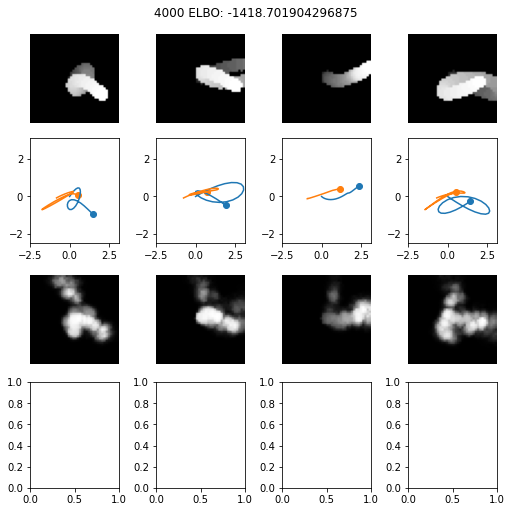

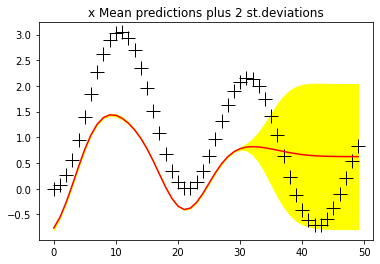

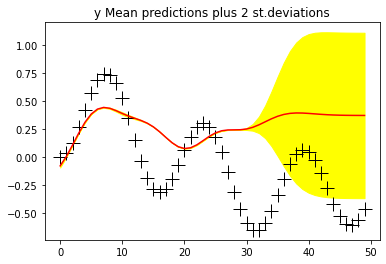


Test set: Avg. loss: 0.0003

Train Epoch: 4050 	Loss: 1408.727783	 1003.179932	 40.554787
Train Epoch: 4100 	Loss: 1399.214355	 992.598145	 40.661617
Train Epoch: 4150 	Loss: 1395.676270	 985.557983	 41.011829
Train Epoch: 4200 	Loss: 1391.142334	 983.249084	 40.789322
Train Epoch: 4250 	Loss: 1379.490601	 966.678467	 41.281212
Train Epoch: 4300 	Loss: 1372.531372	 962.282104	 41.024925
Train Epoch: 4350 	Loss: 1361.815796	 946.630920	 41.518486
Train Epoch: 4400 	Loss: 1364.537354	 950.572876	 41.396454
Train Epoch: 4450 	Loss: 1351.952393	 933.853149	 41.809921
Train Epoch: 4500 	Loss: 1347.244385	 924.705322	 42.253906
Train Epoch: 4550 	Loss: 1342.692139	 927.089844	 41.560230
Train Epoch: 4600 	Loss: 1331.687378	 913.822632	 41.786476
Train Epoch: 4650 	Loss: 1333.143066	 915.665100	 41.747791
Train Epoch: 4700 	Loss: 1321.537231	 904.561157	 41.697609
Train Epoch: 4750 	Loss: 1318.927002	 897.909119	 42.101791
Train Epoch: 4800 	Loss: 1306.459717	 881.796509	 42.466328
Train Epo

<Figure size 432x288 with 0 Axes>

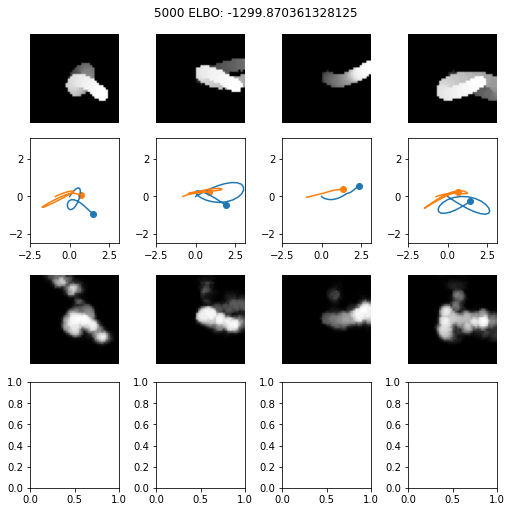

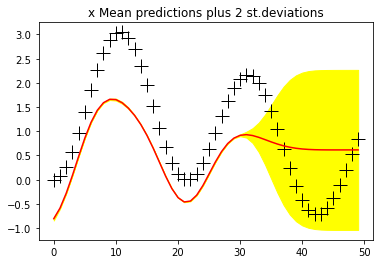

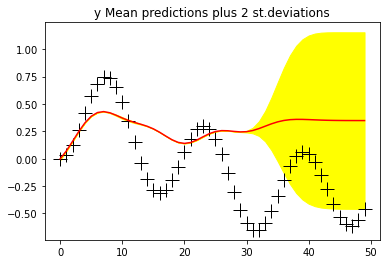


Test set: Avg. loss: 0.0003

Train Epoch: 5050 	Loss: 1283.634888	 850.774475	 43.286041
Train Epoch: 5100 	Loss: 1282.113281	 850.639526	 43.147369
Train Epoch: 5150 	Loss: 1275.229004	 846.759277	 42.846977
Train Epoch: 5200 	Loss: 1274.201904	 842.277039	 43.192482
Train Epoch: 5250 	Loss: 1263.366089	 836.978821	 42.638729
Train Epoch: 5300 	Loss: 1261.541260	 826.814392	 43.472694
Train Epoch: 5350 	Loss: 1254.540771	 819.938416	 43.460228
Train Epoch: 5400 	Loss: 1257.450195	 826.368835	 43.108131
Train Epoch: 5450 	Loss: 1255.476318	 820.028076	 43.544830
Train Epoch: 5500 	Loss: 1242.312744	 811.548340	 43.076439
Train Epoch: 5550 	Loss: 1247.043945	 813.963501	 43.308048
Train Epoch: 5600 	Loss: 1226.419922	 792.308899	 43.411102
Train Epoch: 5650 	Loss: 1230.566284	 794.684753	 43.588150
Train Epoch: 5700 	Loss: 1228.408691	 791.750488	 43.665821
Train Epoch: 5750 	Loss: 1223.270630	 782.716309	 44.055431
Train Epoch: 5800 	Loss: 1222.563965	 783.498108	 43.906582
Train Epoc

<Figure size 432x288 with 0 Axes>

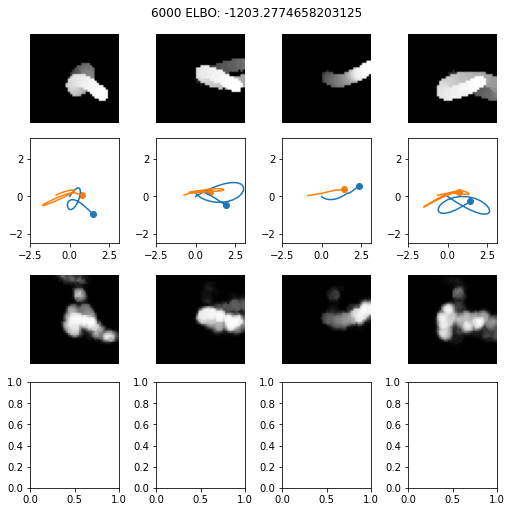

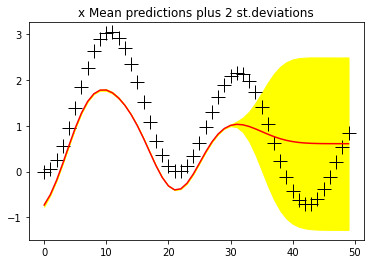

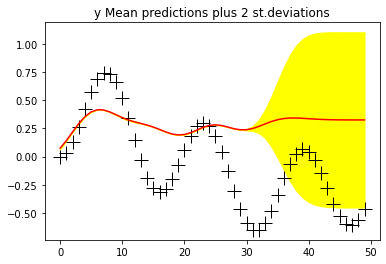


Test set: Avg. loss: 0.0003

Train Epoch: 6050 	Loss: 1198.440552	 756.790100	 44.165043
Train Epoch: 6100 	Loss: 1190.079590	 750.150940	 43.992870
Train Epoch: 6150 	Loss: 1192.926025	 751.436462	 44.148956
Train Epoch: 6200 	Loss: 1188.849121	 743.489380	 44.535976
Train Epoch: 6250 	Loss: 1186.988037	 738.755798	 44.823231
Train Epoch: 6300 	Loss: 1186.167969	 738.733582	 44.743443
Train Epoch: 6350 	Loss: 1185.077026	 742.398804	 44.267826
Train Epoch: 6400 	Loss: 1178.820801	 735.032471	 44.378834
Train Epoch: 6450 	Loss: 1173.800049	 725.306580	 44.849346
Train Epoch: 6500 	Loss: 1173.813843	 725.632019	 44.818184
Train Epoch: 6550 	Loss: 1176.657349	 728.331665	 44.832565
Train Epoch: 6600 	Loss: 1162.209351	 717.315674	 44.489365
Train Epoch: 6650 	Loss: 1164.227295	 711.570618	 45.265663
Train Epoch: 6700 	Loss: 1159.389404	 709.715881	 44.967350
Train Epoch: 6750 	Loss: 1160.014160	 710.002258	 45.001186
Train Epoch: 6800 	Loss: 1151.487793	 700.872314	 45.061543
Train Epoc

<Figure size 432x288 with 0 Axes>

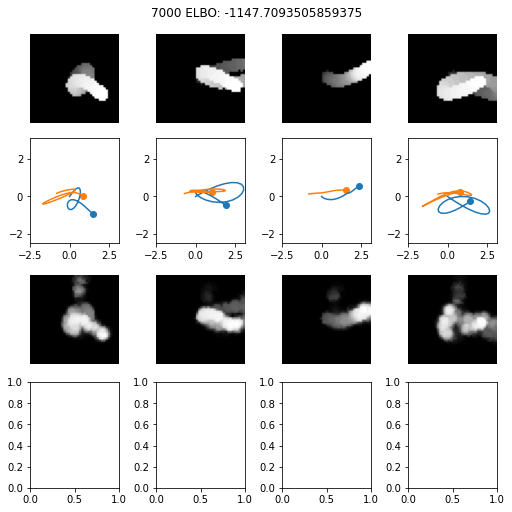

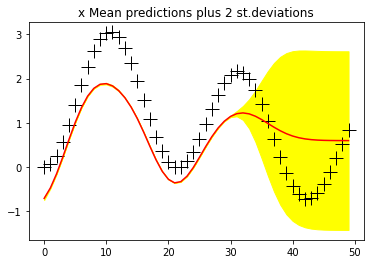

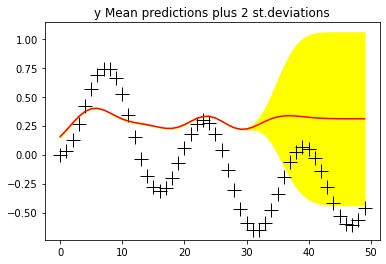


Test set: Avg. loss: 0.0003

Train Epoch: 7050 	Loss: 1141.660034	 689.263306	 45.239674
Train Epoch: 7100 	Loss: 1140.405762	 683.153748	 45.725197
Train Epoch: 7150 	Loss: 1134.129150	 682.147888	 45.198120
Train Epoch: 7200 	Loss: 1139.912842	 681.252319	 45.866051
Train Epoch: 7250 	Loss: 1129.882690	 669.505127	 46.037758
Train Epoch: 7300 	Loss: 1133.989502	 676.158997	 45.783047
Train Epoch: 7350 	Loss: 1130.712036	 670.121033	 46.059101
Train Epoch: 7400 	Loss: 1128.789307	 674.459778	 45.432945
Train Epoch: 7450 	Loss: 1125.710938	 666.479980	 45.923092
Train Epoch: 7500 	Loss: 1122.372314	 660.469299	 46.190296
Train Epoch: 7550 	Loss: 1119.680908	 661.820801	 45.786015
Train Epoch: 7600 	Loss: 1116.702148	 655.927429	 46.077477
Train Epoch: 7650 	Loss: 1119.844727	 660.057739	 45.978691
Train Epoch: 7700 	Loss: 1118.541992	 658.233276	 46.030872
Train Epoch: 7750 	Loss: 1116.372681	 654.579468	 46.179325
Train Epoch: 7800 	Loss: 1108.273926	 646.674561	 46.159943
Train Epoc

<Figure size 432x288 with 0 Axes>

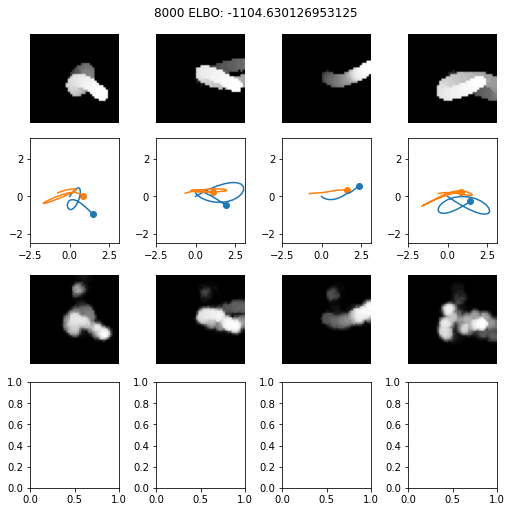

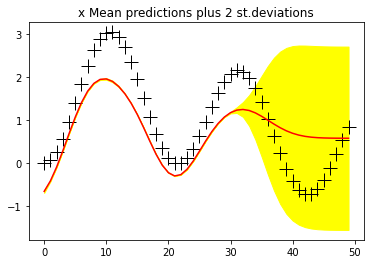

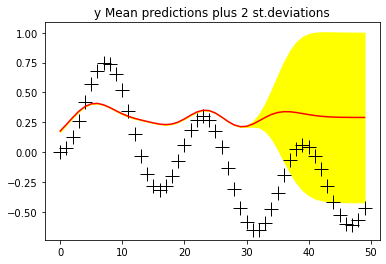


Test set: Avg. loss: 0.0003

Train Epoch: 8050 	Loss: 1106.317749	 644.976807	 46.134090
Train Epoch: 8100 	Loss: 1106.132568	 643.801819	 46.233070
Train Epoch: 8150 	Loss: 1097.935791	 633.410339	 46.452553
Train Epoch: 8200 	Loss: 1099.951416	 634.118286	 46.583305
Train Epoch: 8250 	Loss: 1098.146973	 635.578308	 46.256870
Train Epoch: 8300 	Loss: 1098.871216	 636.473328	 46.239792
Train Epoch: 8350 	Loss: 1095.633423	 632.020325	 46.361309
Train Epoch: 8400 	Loss: 1096.766602	 630.552979	 46.621361
Train Epoch: 8450 	Loss: 1092.041138	 625.823792	 46.621735
Train Epoch: 8500 	Loss: 1093.710938	 629.516541	 46.419437
Train Epoch: 8550 	Loss: 1089.784058	 623.245667	 46.653843
Train Epoch: 8600 	Loss: 1085.819214	 619.164856	 46.665436
Train Epoch: 8650 	Loss: 1088.323486	 619.253601	 46.906986
Train Epoch: 8700 	Loss: 1085.717041	 623.600586	 46.211639
Train Epoch: 8750 	Loss: 1081.617310	 611.182312	 47.043503
Train Epoch: 8800 	Loss: 1082.143799	 615.877869	 46.626591
Train Epoc

<Figure size 432x288 with 0 Axes>

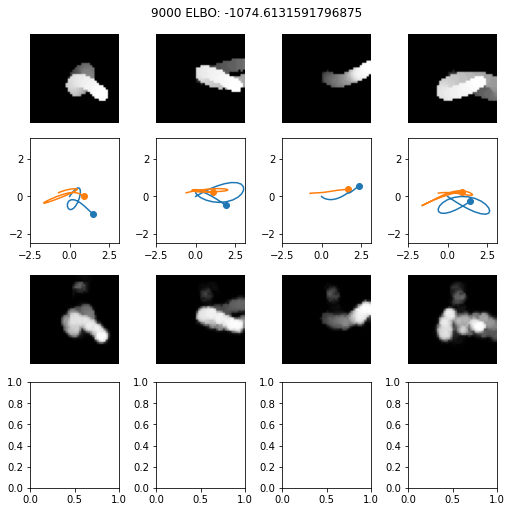

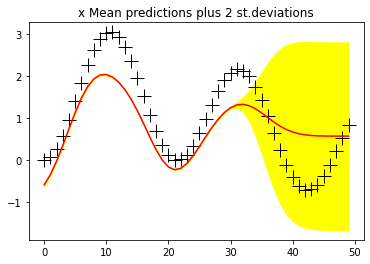

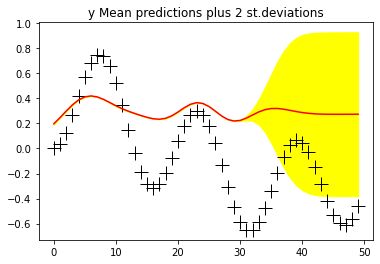


Test set: Avg. loss: 0.0002

Train Epoch: 9050 	Loss: 1081.548340	 610.773071	 47.077526
Train Epoch: 9100 	Loss: 1068.292480	 599.873901	 46.841854
Train Epoch: 9150 	Loss: 1077.247681	 609.879517	 46.736816
Train Epoch: 9200 	Loss: 1070.266602	 600.415222	 46.985130
Train Epoch: 9250 	Loss: 1073.255371	 603.119019	 47.013638
Train Epoch: 9300 	Loss: 1073.942261	 603.750977	 47.019127
Train Epoch: 9350 	Loss: 1075.651978	 605.046509	 47.060547
Train Epoch: 9400 	Loss: 1071.205566	 603.617249	 46.758827
Train Epoch: 9450 	Loss: 1069.746826	 595.057800	 47.468903
Train Epoch: 9500 	Loss: 1067.305176	 600.211182	 46.709404
Train Epoch: 9550 	Loss: 1067.304077	 593.552368	 47.375168
Train Epoch: 9600 	Loss: 1062.361572	 593.438293	 46.892323
Train Epoch: 9650 	Loss: 1066.411133	 594.771545	 47.163963
Train Epoch: 9700 	Loss: 1062.651367	 587.036682	 47.561474
Train Epoch: 9750 	Loss: 1058.966675	 583.658020	 47.530869
Train Epoch: 9800 	Loss: 1058.965454	 582.682861	 47.628262
Train Epoc

<Figure size 432x288 with 0 Axes>

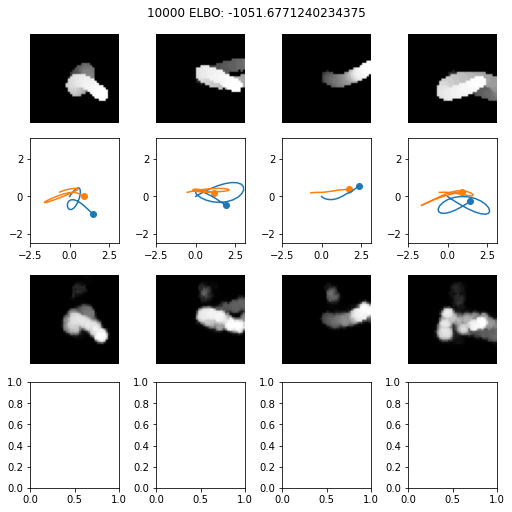

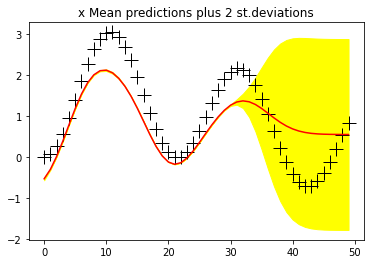

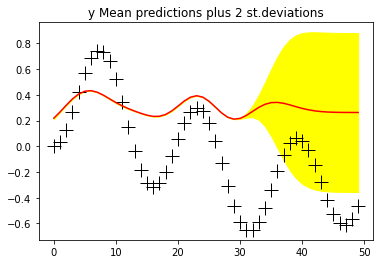


Test set: Avg. loss: 0.0002

Train Epoch: 10050 	Loss: 1053.328125	 580.823303	 47.250484
Train Epoch: 10100 	Loss: 1050.098755	 576.937500	 47.316124
Train Epoch: 10150 	Loss: 1049.599609	 571.352844	 47.824684
Train Epoch: 10200 	Loss: 1052.398682	 575.070557	 47.732819
Train Epoch: 10250 	Loss: 1053.613525	 578.816040	 47.479755
Train Epoch: 10300 	Loss: 1042.595093	 563.906616	 47.868851
Train Epoch: 10350 	Loss: 1047.675537	 571.321045	 47.635448
Train Epoch: 10400 	Loss: 1045.712891	 573.305847	 47.240704
Train Epoch: 10450 	Loss: 1054.339600	 577.305969	 47.703365
Train Epoch: 10500 	Loss: 1045.857422	 568.984314	 47.687309
Train Epoch: 10550 	Loss: 1046.396973	 569.365479	 47.703156
Train Epoch: 10600 	Loss: 1042.747314	 567.350464	 47.539688
Train Epoch: 10650 	Loss: 1044.327026	 567.590881	 47.673618
Train Epoch: 10700 	Loss: 1041.599609	 561.531006	 48.006866
Train Epoch: 10750 	Loss: 1039.571899	 561.767944	 47.780396
Train Epoch: 10800 	Loss: 1040.629150	 567.197754	 47.3

<Figure size 432x288 with 0 Axes>

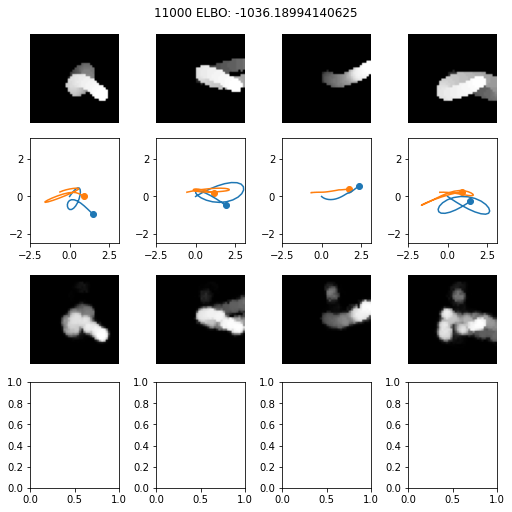

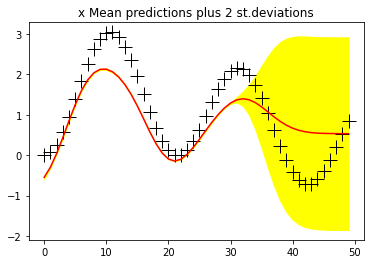

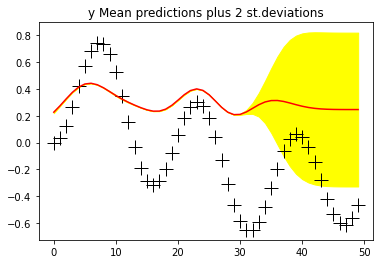


Test set: Avg. loss: 0.0002

Train Epoch: 11050 	Loss: 1033.350708	 556.255432	 47.709530
Train Epoch: 11100 	Loss: 1041.941528	 565.612915	 47.632858
Train Epoch: 11150 	Loss: 1033.797852	 556.738647	 47.705914
Train Epoch: 11200 	Loss: 1033.193848	 553.349548	 47.984425
Train Epoch: 11250 	Loss: 1031.891113	 550.124207	 48.176689
Train Epoch: 11300 	Loss: 1040.639526	 559.553589	 48.108597
Train Epoch: 11350 	Loss: 1034.996338	 557.980957	 47.701534
Train Epoch: 11400 	Loss: 1035.297974	 555.281433	 48.001656
Train Epoch: 11450 	Loss: 1032.758789	 551.096069	 48.166275
Train Epoch: 11500 	Loss: 1032.817383	 551.218506	 48.159882
Train Epoch: 11550 	Loss: 1029.636841	 548.419922	 48.121689
Train Epoch: 11600 	Loss: 1038.151123	 557.326111	 48.082508
Train Epoch: 11650 	Loss: 1027.038696	 542.497375	 48.454136
Train Epoch: 11700 	Loss: 1022.510864	 538.284241	 48.422661
Train Epoch: 11750 	Loss: 1026.369507	 548.043701	 47.832584
Train Epoch: 11800 	Loss: 1035.938477	 555.878906	 48.0

<Figure size 432x288 with 0 Axes>

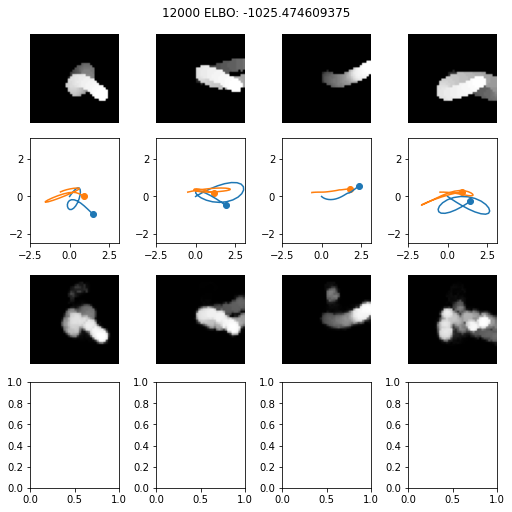

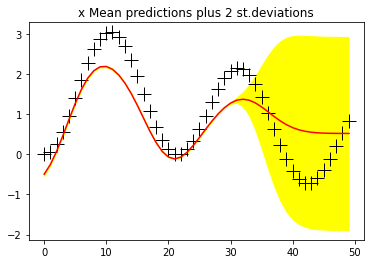

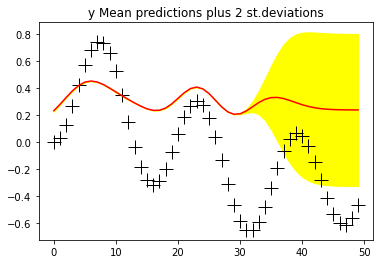


Test set: Avg. loss: 0.0002

Train Epoch: 12050 	Loss: 1033.477295	 548.893127	 48.458412
Train Epoch: 12100 	Loss: 1025.049927	 537.741577	 48.730831
Train Epoch: 12150 	Loss: 1017.748718	 534.536682	 48.321205
Train Epoch: 12200 	Loss: 1023.732544	 542.323853	 48.140873
Train Epoch: 12250 	Loss: 1016.644592	 533.586426	 48.305817
Train Epoch: 12300 	Loss: 1015.908264	 534.586121	 48.132214
Train Epoch: 12350 	Loss: 1025.593994	 537.823669	 48.777035
Train Epoch: 12400 	Loss: 1017.774170	 528.892273	 48.888187
Train Epoch: 12450 	Loss: 1016.626343	 532.742615	 48.388371
Train Epoch: 12500 	Loss: 1018.440674	 529.747803	 48.869286
Train Epoch: 12550 	Loss: 1016.030273	 529.360962	 48.666935
Train Epoch: 12600 	Loss: 1017.741455	 536.045837	 48.169559
Train Epoch: 12650 	Loss: 1014.014709	 528.766235	 48.524849
Train Epoch: 12700 	Loss: 1015.065247	 528.305176	 48.676006
Train Epoch: 12750 	Loss: 1010.750916	 520.500488	 49.025043
Train Epoch: 12800 	Loss: 1021.272949	 529.810547	 49.1

<Figure size 432x288 with 0 Axes>

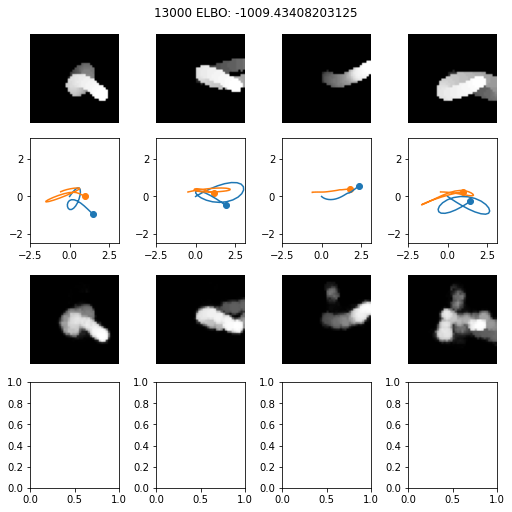

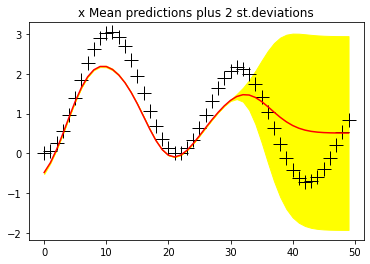

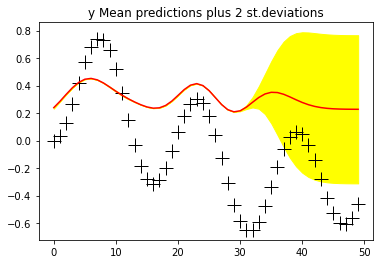


Test set: Avg. loss: 0.0002

Train Epoch: 13050 	Loss: 1009.982849	 523.915100	 48.606773
Train Epoch: 13100 	Loss: 1009.661865	 519.548157	 49.011372
Train Epoch: 13150 	Loss: 1013.377319	 524.077881	 48.929943
Train Epoch: 13200 	Loss: 1014.846802	 528.023804	 48.682297
Train Epoch: 13250 	Loss: 1007.536865	 516.913452	 49.062344
Train Epoch: 13300 	Loss: 1003.699402	 513.881836	 48.981758
Train Epoch: 13350 	Loss: 1006.742676	 518.613892	 48.812881
Train Epoch: 13400 	Loss: 1007.359863	 522.555176	 48.480465
Train Epoch: 13450 	Loss: 1004.916138	 515.843567	 48.907261
Train Epoch: 13500 	Loss: 1009.374939	 522.134399	 48.724052
Train Epoch: 13550 	Loss: 1011.540283	 520.361816	 49.117847
Train Epoch: 13600 	Loss: 1007.067810	 521.441589	 48.562622
Train Epoch: 13650 	Loss: 1011.345215	 523.925537	 48.741966
Train Epoch: 13700 	Loss: 1005.773560	 514.466614	 49.130692
Train Epoch: 13750 	Loss: 1005.359985	 519.307434	 48.605255
Train Epoch: 13800 	Loss: 1004.283020	 515.881897	 48.8

<Figure size 432x288 with 0 Axes>

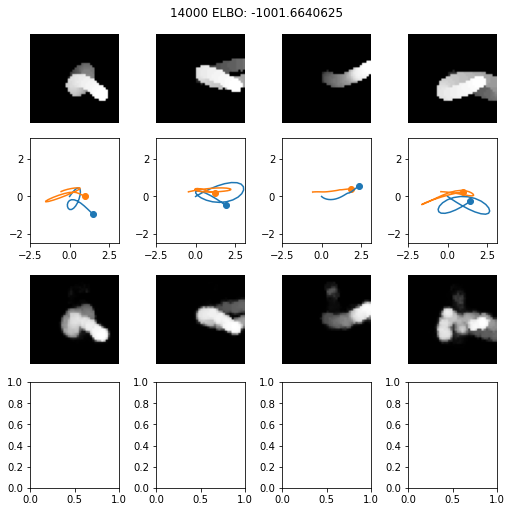

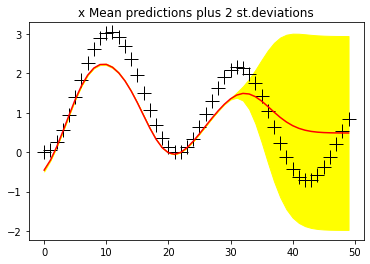

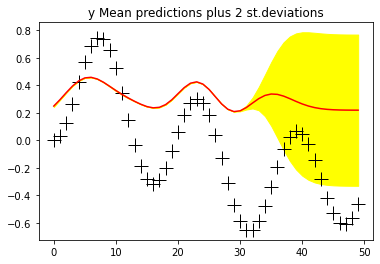


Test set: Avg. loss: 0.0002

Train Epoch: 14050 	Loss: 1000.786499	 512.895142	 48.789139
Train Epoch: 14100 	Loss: 1000.689575	 510.850677	 48.983887
Train Epoch: 14150 	Loss: 1003.728027	 513.551636	 49.017635
Train Epoch: 14200 	Loss: 1001.713135	 514.937683	 48.677547
Train Epoch: 14250 	Loss: 999.586792	 510.434875	 48.915192
Train Epoch: 14300 	Loss: 994.728333	 507.348267	 48.738007
Train Epoch: 14350 	Loss: 1003.433350	 511.507690	 49.192570
Train Epoch: 14400 	Loss: 1000.849121	 508.793060	 49.205605
Train Epoch: 14450 	Loss: 998.591797	 507.151398	 49.144043
Train Epoch: 14500 	Loss: 997.337524	 506.502960	 49.083458
Train Epoch: 14550 	Loss: 1000.549927	 507.074249	 49.347569
Train Epoch: 14600 	Loss: 995.416260	 506.237976	 48.917831
Train Epoch: 14650 	Loss: 998.463318	 506.742859	 49.172047
Train Epoch: 14700 	Loss: 990.419006	 496.498566	 49.392044
Train Epoch: 14750 	Loss: 992.776733	 505.102356	 48.767437
Train Epoch: 14800 	Loss: 993.761108	 496.747955	 49.701317
Tra

<Figure size 432x288 with 0 Axes>

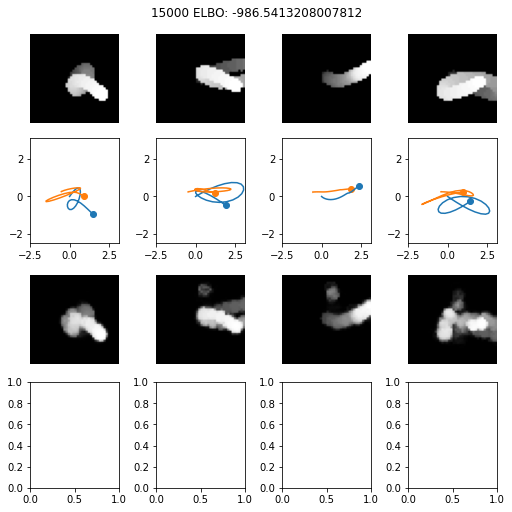

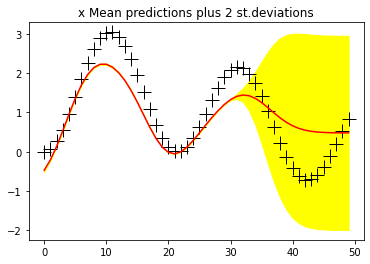

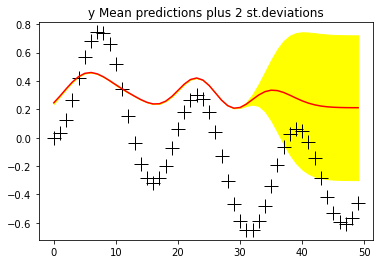


Test set: Avg. loss: 0.0002

Train Epoch: 15050 	Loss: 995.380005	 504.479584	 49.090038
Train Epoch: 15100 	Loss: 998.274475	 507.903687	 49.037079
Train Epoch: 15150 	Loss: 990.568481	 498.832642	 49.173580
Train Epoch: 15200 	Loss: 987.393433	 495.664429	 49.172901
Train Epoch: 15250 	Loss: 991.470154	 495.999298	 49.547085
Train Epoch: 15300 	Loss: 988.110901	 500.206177	 48.790474
Train Epoch: 15350 	Loss: 990.715088	 499.171753	 49.154331
Train Epoch: 15400 	Loss: 985.461609	 494.564636	 49.089699
Train Epoch: 15450 	Loss: 991.348633	 497.182098	 49.416656
Train Epoch: 15500 	Loss: 982.490540	 489.376556	 49.311398
Train Epoch: 15550 	Loss: 991.507568	 500.020203	 49.148739
Train Epoch: 15600 	Loss: 985.629456	 491.311340	 49.431812
Train Epoch: 15650 	Loss: 985.092651	 490.774536	 49.431808
Train Epoch: 15700 	Loss: 987.224365	 496.223877	 49.100052
Train Epoch: 15750 	Loss: 981.092590	 487.460968	 49.363163
Train Epoch: 15800 	Loss: 985.283264	 490.112915	 49.517036
Train Epoc

<Figure size 432x288 with 0 Axes>

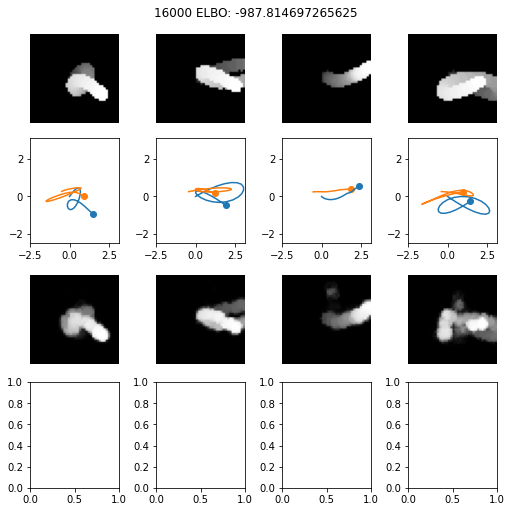

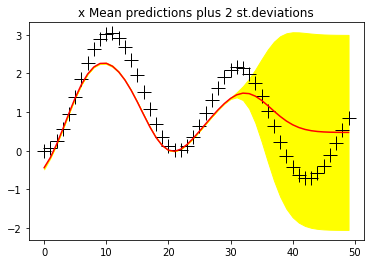

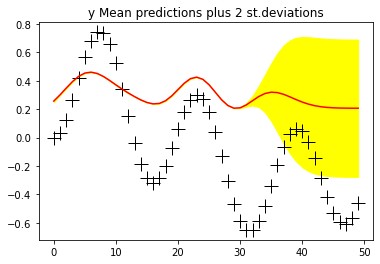


Test set: Avg. loss: 0.0002

Train Epoch: 16050 	Loss: 980.714233	 484.166443	 49.654781
Train Epoch: 16100 	Loss: 980.810913	 487.725433	 49.308544
Train Epoch: 16150 	Loss: 982.196655	 493.443878	 48.875282
Train Epoch: 16200 	Loss: 979.793945	 486.987183	 49.280674
Train Epoch: 16250 	Loss: 981.108643	 484.770508	 49.633812
Train Epoch: 16300 	Loss: 979.585083	 487.126251	 49.245888
Train Epoch: 16350 	Loss: 982.016113	 486.823639	 49.519249
Train Epoch: 16400 	Loss: 983.364990	 489.011017	 49.435394
Train Epoch: 16450 	Loss: 987.369202	 490.653015	 49.671619
Train Epoch: 16500 	Loss: 980.038696	 481.179169	 49.885948
Train Epoch: 16550 	Loss: 977.631714	 483.361694	 49.426998
Train Epoch: 16600 	Loss: 978.643677	 483.886292	 49.475742
Train Epoch: 16650 	Loss: 983.980713	 488.669098	 49.531166
Train Epoch: 16700 	Loss: 979.879456	 486.407898	 49.347157
Train Epoch: 16750 	Loss: 979.666931	 486.731018	 49.293591
Train Epoch: 16800 	Loss: 974.516968	 480.218506	 49.429844
Train Epoc

<Figure size 432x288 with 0 Axes>

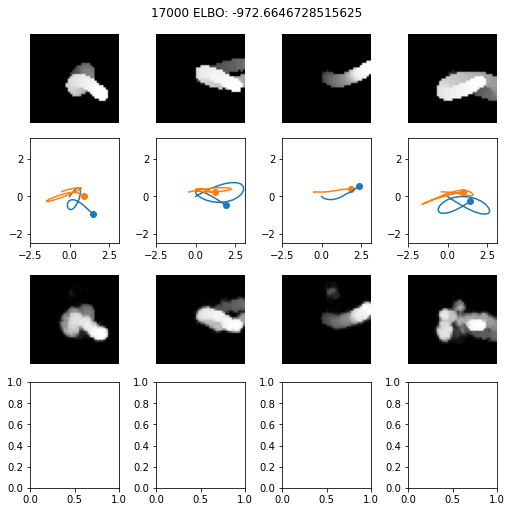

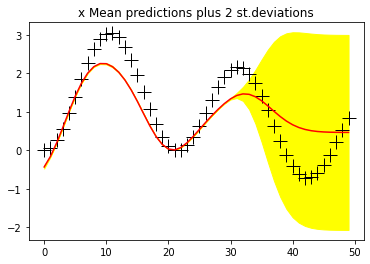

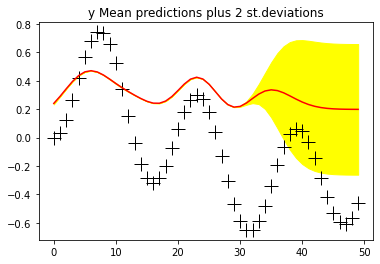


Test set: Avg. loss: 0.0002

Train Epoch: 17050 	Loss: 968.028625	 468.026215	 50.000240
Train Epoch: 17100 	Loss: 977.683594	 480.122345	 49.756123
Train Epoch: 17150 	Loss: 974.451050	 473.565704	 50.088535
Train Epoch: 17200 	Loss: 979.690674	 485.051514	 49.463913
Train Epoch: 17250 	Loss: 973.895325	 479.600128	 49.429520
Train Epoch: 17300 	Loss: 968.888306	 473.685242	 49.520309
Train Epoch: 17350 	Loss: 976.022217	 474.712738	 50.130943
Train Epoch: 17400 	Loss: 969.157715	 469.539917	 49.961781
Train Epoch: 17450 	Loss: 974.411377	 474.529572	 49.988178
Train Epoch: 17500 	Loss: 970.523560	 473.164673	 49.735889
Train Epoch: 17550 	Loss: 972.632324	 475.000305	 49.763203
Train Epoch: 17600 	Loss: 970.884155	 469.741882	 50.114227
Train Epoch: 17650 	Loss: 968.034790	 470.752838	 49.728195
Train Epoch: 17700 	Loss: 964.307251	 462.861481	 50.144577
Train Epoch: 17750 	Loss: 977.377625	 482.917023	 49.446060
Train Epoch: 17800 	Loss: 974.944702	 477.228271	 49.771641
Train Epoc

<Figure size 432x288 with 0 Axes>

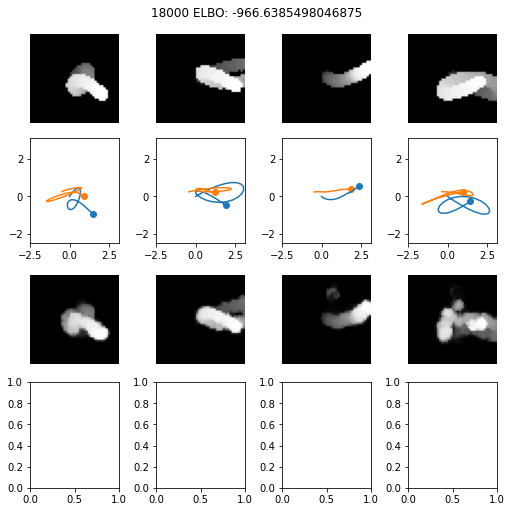

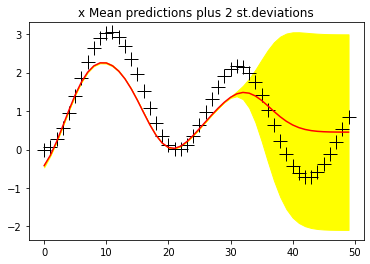

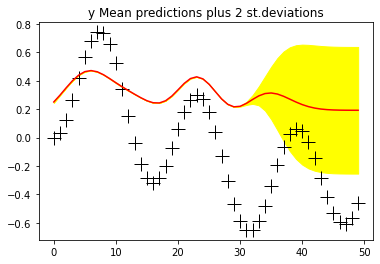


Test set: Avg. loss: 0.0002

Train Epoch: 18050 	Loss: 972.831970	 471.560455	 50.127151
Train Epoch: 18100 	Loss: 973.754944	 473.669464	 50.008549
Train Epoch: 18150 	Loss: 968.621948	 471.781372	 49.684059
Train Epoch: 18200 	Loss: 969.866455	 471.824402	 49.804203
Train Epoch: 18250 	Loss: 968.228333	 468.983917	 49.924442
Train Epoch: 18300 	Loss: 963.317017	 462.190460	 50.112659
Train Epoch: 18350 	Loss: 964.822876	 462.906677	 50.191616
Train Epoch: 18400 	Loss: 965.535767	 464.064850	 50.147095
Train Epoch: 18450 	Loss: 965.841614	 464.113983	 50.172764
Train Epoch: 18500 	Loss: 969.120605	 471.087006	 49.803360
Train Epoch: 18550 	Loss: 968.900085	 471.064880	 49.783520
Train Epoch: 18600 	Loss: 966.542969	 465.676727	 50.086624
Train Epoch: 18650 	Loss: 963.286865	 462.270386	 50.101650
Train Epoch: 18700 	Loss: 965.295898	 465.182159	 50.011375
Train Epoch: 18750 	Loss: 967.306030	 467.047668	 50.025833
Train Epoch: 18800 	Loss: 962.628357	 463.122894	 49.950546
Train Epoc

<Figure size 432x288 with 0 Axes>

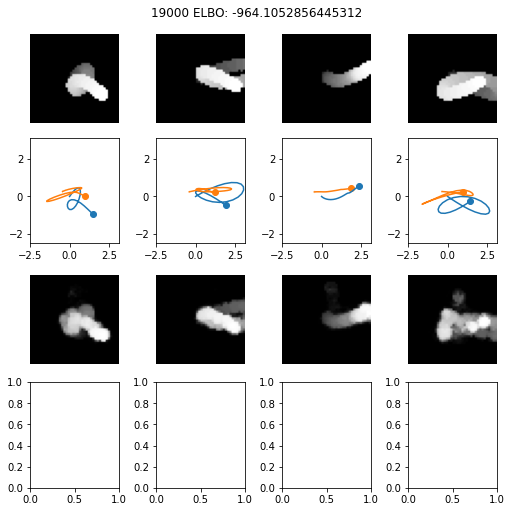

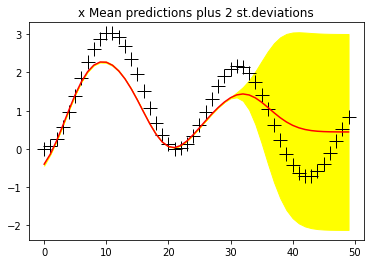

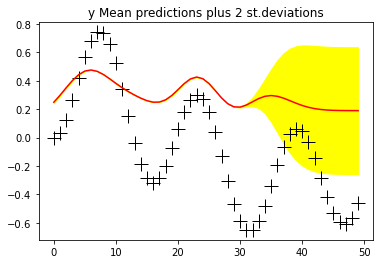


Test set: Avg. loss: 0.0002

Train Epoch: 19050 	Loss: 965.469666	 462.088470	 50.338120
Train Epoch: 19100 	Loss: 963.658569	 465.996704	 49.766190
Train Epoch: 19150 	Loss: 967.411499	 466.458893	 50.095261
Train Epoch: 19200 	Loss: 963.637329	 461.839386	 50.179794
Train Epoch: 19250 	Loss: 964.170837	 463.478394	 50.069244
Train Epoch: 19300 	Loss: 968.479492	 462.619232	 50.586025
Train Epoch: 19350 	Loss: 958.520508	 461.808624	 49.671192
Train Epoch: 19400 	Loss: 957.691956	 456.796600	 50.089535
Train Epoch: 19450 	Loss: 957.478149	 455.221008	 50.225712
Train Epoch: 19500 	Loss: 962.320312	 462.309998	 50.001030
Train Epoch: 19550 	Loss: 962.024170	 457.243256	 50.478096
Train Epoch: 19600 	Loss: 957.786987	 456.119568	 50.166744
Train Epoch: 19650 	Loss: 959.553772	 457.334778	 50.221901
Train Epoch: 19700 	Loss: 955.455566	 450.102417	 50.535316
Train Epoch: 19750 	Loss: 959.836792	 453.419739	 50.641708
Train Epoch: 19800 	Loss: 957.679810	 456.149323	 50.153053
Train Epoc

<Figure size 432x288 with 0 Axes>

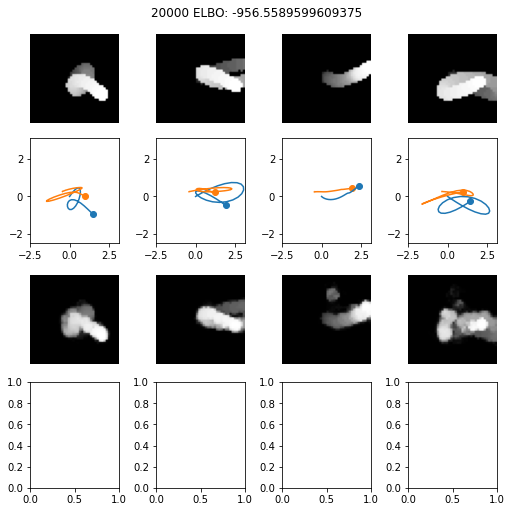

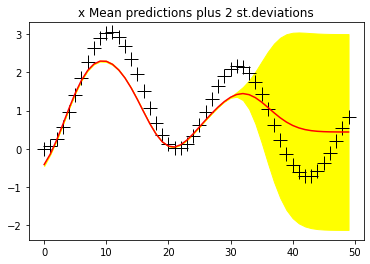

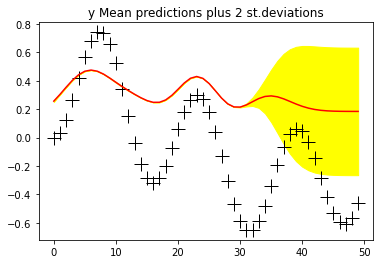


Test set: Avg. loss: 0.0002

Train Epoch: 20050 	Loss: 960.655884	 459.214600	 50.144131
Train Epoch: 20100 	Loss: 951.654663	 448.162415	 50.349224
Train Epoch: 20150 	Loss: 955.825684	 453.541473	 50.228416
Train Epoch: 20200 	Loss: 958.632080	 452.190857	 50.644119
Train Epoch: 20250 	Loss: 956.438721	 454.388245	 50.205044
Train Epoch: 20300 	Loss: 955.597900	 452.024933	 50.357296
Train Epoch: 20350 	Loss: 959.094360	 457.030243	 50.206409
Train Epoch: 20400 	Loss: 961.948242	 459.015930	 50.293232
Train Epoch: 20450 	Loss: 952.930786	 448.479919	 50.445087
Train Epoch: 20500 	Loss: 957.472046	 453.626099	 50.384594
Train Epoch: 20550 	Loss: 957.976074	 454.085968	 50.389015
Train Epoch: 20600 	Loss: 953.311279	 451.595459	 50.171585
Train Epoch: 20650 	Loss: 950.190186	 449.601807	 50.058838
Train Epoch: 20700 	Loss: 951.607666	 446.979401	 50.462826
Train Epoch: 20750 	Loss: 957.322327	 450.069489	 50.725285
Train Epoch: 20800 	Loss: 956.111572	 450.995392	 50.511620
Train Epoc

<Figure size 432x288 with 0 Axes>

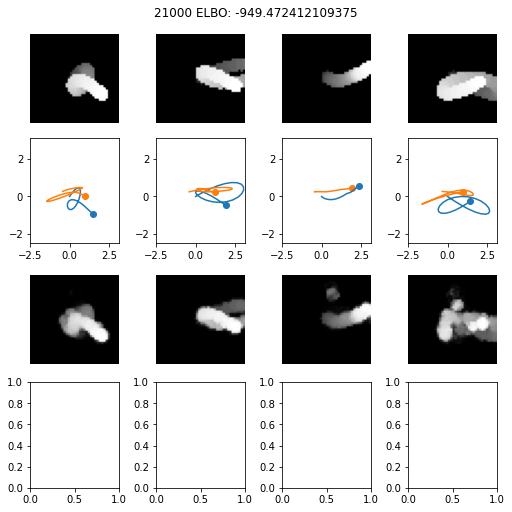

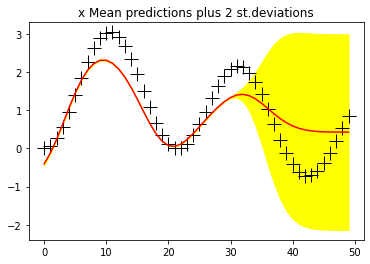

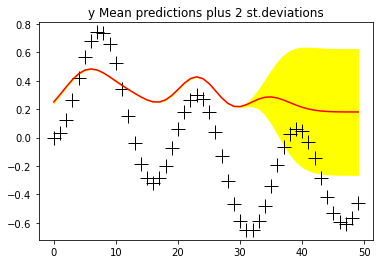


Test set: Avg. loss: 0.0002

Train Epoch: 21050 	Loss: 947.807617	 446.859802	 50.094780
Train Epoch: 21100 	Loss: 956.516602	 451.476379	 50.504025
Train Epoch: 21150 	Loss: 946.156311	 445.106628	 50.104969
Train Epoch: 21200 	Loss: 949.805725	 446.096008	 50.370972
Train Epoch: 21250 	Loss: 951.959900	 446.640198	 50.531971
Train Epoch: 21300 	Loss: 946.994080	 441.825378	 50.516869
Train Epoch: 21350 	Loss: 944.929077	 440.177277	 50.475182
Train Epoch: 21400 	Loss: 945.054321	 438.747437	 50.630688
Train Epoch: 21450 	Loss: 954.483887	 454.158752	 50.032516
Train Epoch: 21500 	Loss: 948.714966	 442.672821	 50.604218
Train Epoch: 21550 	Loss: 948.259460	 440.288605	 50.797085
Train Epoch: 21600 	Loss: 947.917725	 444.272644	 50.364506
Train Epoch: 21650 	Loss: 947.013306	 443.443939	 50.356937
Train Epoch: 21700 	Loss: 944.614502	 438.106354	 50.650814
Train Epoch: 21750 	Loss: 944.943970	 437.065399	 50.787861
Train Epoch: 21800 	Loss: 943.570557	 437.298737	 50.627186
Train Epoc

<Figure size 432x288 with 0 Axes>

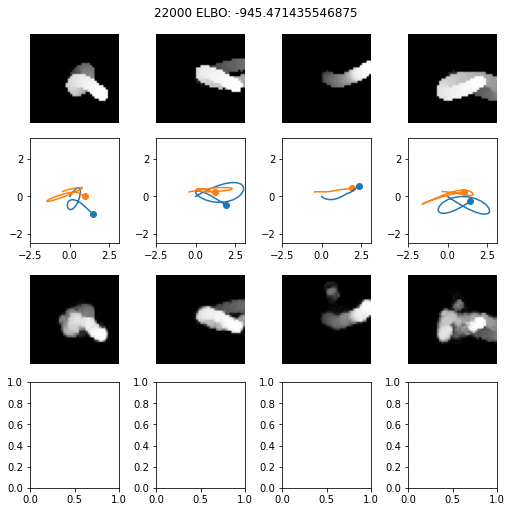

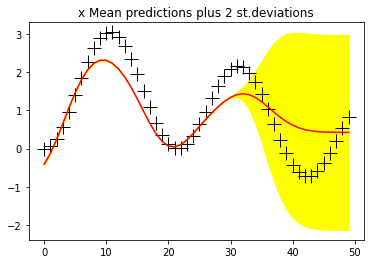

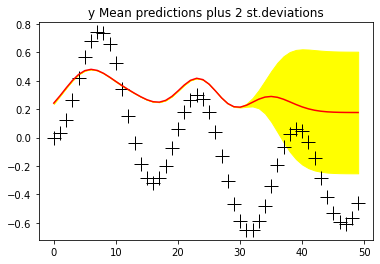


Test set: Avg. loss: 0.0002

Train Epoch: 22050 	Loss: 946.487976	 440.937073	 50.555092
Train Epoch: 22100 	Loss: 946.432617	 439.619598	 50.681297
Train Epoch: 22150 	Loss: 948.119873	 442.842651	 50.527725
Train Epoch: 22200 	Loss: 948.399902	 441.497894	 50.690197
Train Epoch: 22250 	Loss: 938.861938	 428.635895	 51.022606
Train Epoch: 22300 	Loss: 948.559143	 440.081207	 50.847794
Train Epoch: 22350 	Loss: 947.737305	 439.708252	 50.802902
Train Epoch: 22400 	Loss: 942.686768	 437.628052	 50.505871
Train Epoch: 22450 	Loss: 941.969543	 432.312897	 50.965664
Train Epoch: 22500 	Loss: 951.562744	 444.686493	 50.687622
Train Epoch: 22550 	Loss: 948.014526	 442.963837	 50.505070
Train Epoch: 22600 	Loss: 947.134705	 440.802887	 50.633183
Train Epoch: 22650 	Loss: 941.774902	 435.222809	 50.655205
Train Epoch: 22700 	Loss: 944.208740	 439.864105	 50.434464
Train Epoch: 22750 	Loss: 943.980225	 433.727234	 51.025303
Train Epoch: 22800 	Loss: 942.940308	 433.733917	 50.920639
Train Epoc

<Figure size 432x288 with 0 Axes>

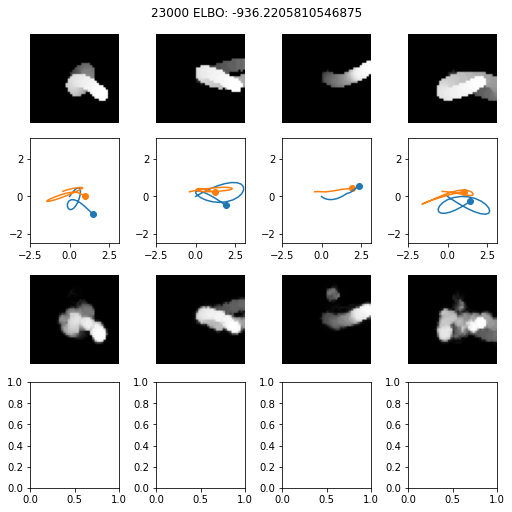

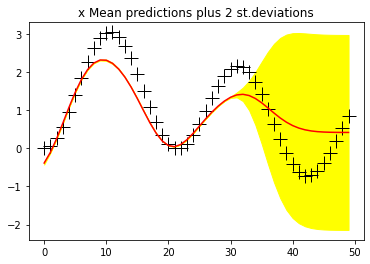

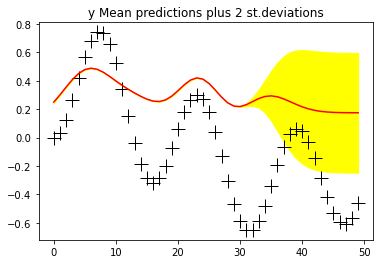


Test set: Avg. loss: 0.0002

Train Epoch: 23050 	Loss: 941.049927	 433.064209	 50.798569
Train Epoch: 23100 	Loss: 943.452637	 434.022278	 50.943039
Train Epoch: 23150 	Loss: 945.658813	 438.417572	 50.724125
Train Epoch: 23200 	Loss: 946.456665	 439.005157	 50.745155
Train Epoch: 23250 	Loss: 936.599609	 428.709290	 50.789028
Train Epoch: 23300 	Loss: 934.620117	 425.307037	 50.931305
Train Epoch: 23350 	Loss: 939.704224	 428.920227	 51.078400
Train Epoch: 23400 	Loss: 940.968628	 428.054657	 51.291397
Train Epoch: 23450 	Loss: 941.204468	 433.410004	 50.779449
Train Epoch: 23500 	Loss: 947.436401	 441.675323	 50.576103
Train Epoch: 23550 	Loss: 945.729980	 438.102020	 50.762794
Train Epoch: 23600 	Loss: 935.641724	 423.986237	 51.165550
Train Epoch: 23650 	Loss: 940.539062	 431.338196	 50.920090
Train Epoch: 23700 	Loss: 940.634827	 429.919495	 51.071533
Train Epoch: 23750 	Loss: 931.839111	 420.791260	 51.104786
Train Epoch: 23800 	Loss: 934.927979	 423.861572	 51.106640
Train Epoc

<Figure size 432x288 with 0 Axes>

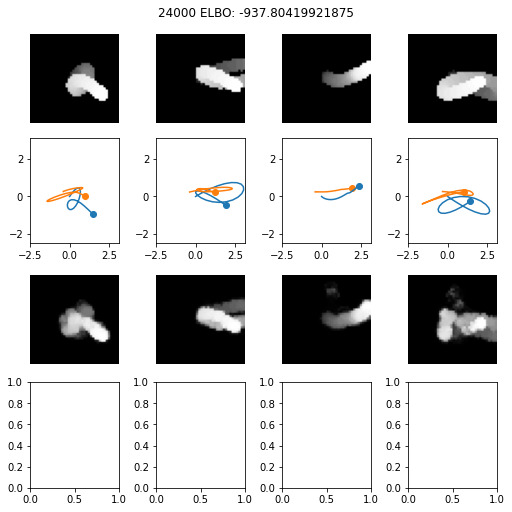

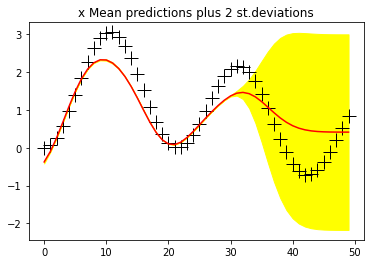

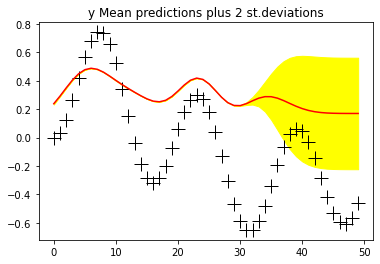


Test set: Avg. loss: 0.0002

Train Epoch: 24050 	Loss: 937.546936	 424.835632	 51.271130
Train Epoch: 24100 	Loss: 935.154480	 426.050232	 50.910423
Train Epoch: 24150 	Loss: 934.836182	 424.685455	 51.015072
Train Epoch: 24200 	Loss: 940.721680	 425.909882	 51.481178
Train Epoch: 24250 	Loss: 938.798523	 429.078796	 50.971973
Train Epoch: 24300 	Loss: 935.268982	 423.950928	 51.131805
Train Epoch: 24350 	Loss: 938.907471	 424.340088	 51.456741
Train Epoch: 24400 	Loss: 934.601929	 423.435791	 51.116611
Train Epoch: 24450 	Loss: 939.282959	 430.936432	 50.834652
Train Epoch: 24500 	Loss: 929.005493	 417.761963	 51.124355
Train Epoch: 24550 	Loss: 931.569519	 417.392273	 51.417725
Train Epoch: 24600 	Loss: 937.647949	 424.605103	 51.304287
Train Epoch: 24650 	Loss: 934.150635	 424.521393	 50.962929
Train Epoch: 24700 	Loss: 938.113403	 429.792023	 50.832138
Train Epoch: 24750 	Loss: 930.576904	 421.039246	 50.953770
Train Epoch: 24800 	Loss: 932.768555	 422.325073	 51.044346
Train Epoc

<Figure size 432x288 with 0 Axes>

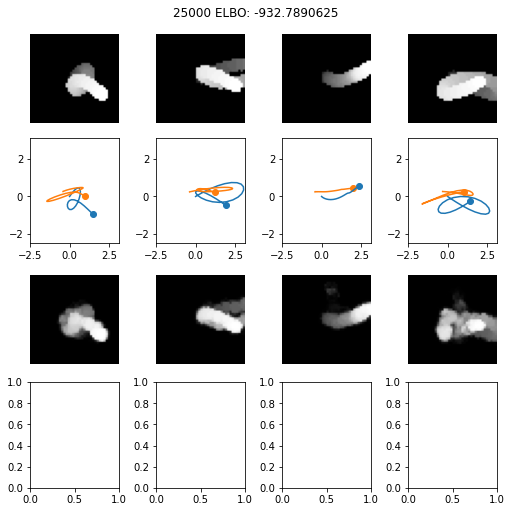

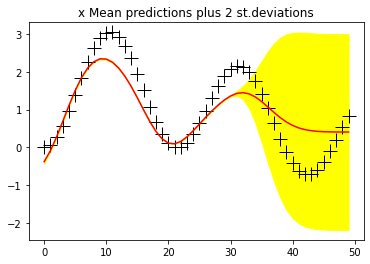

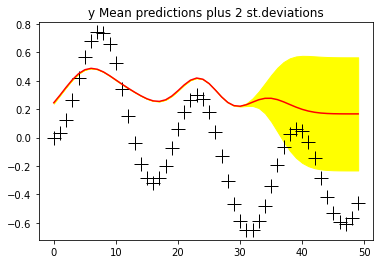


Test set: Avg. loss: 0.0002

Train Epoch: 25050 	Loss: 931.488892	 418.990936	 51.249790
Train Epoch: 25100 	Loss: 934.853149	 424.946564	 50.990654
Train Epoch: 25150 	Loss: 929.963318	 420.302368	 50.966095


In [ ]:

    args_steps=50000 #Number of steps of Adam
    args_modellt=5. #time scale of model to fit to data
    args_base_dir="./" #folder within a new dir is made for each run
    args_l1=0.3 #Parameters for physical kernel (not used here)
    args_l2=0.4
    args_d1=0.02
    args_d2=0.01

    run_experiment(args_steps,args_modellt,args_base_dir,args_l1,args_l2,args_d1,args_d2)